# Reinforcement Learning Basics

In [9]:
from ctf import SimpleCTF
from utils import policy, update_state_action_values, play_episode_from_policy, softmax
from collections import defaultdict
import time
import numpy as np
import matplotlib.pyplot as plt


In [10]:
ctf = SimpleCTF()
ctf.grid

array([[0, 0, 0, 3],
       [0, 0, 0, 0],
       [0, 0, 2, 2],
       [0, 0, 1, 0]], dtype=uint8)

In [11]:
n_steps = 3
ctf.reset()
for i in range(n_steps):
    ctf.render()
    action = np.random.randint(0, 4)
    ctf.step(action)

(3, 2, 0) 
 [[0 0 0 3]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 1 0]] 

(3, 3, 0) 
 [[0 0 0 3]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 0 1]] 

(3, 2, 0) 
 [[0 0 0 3]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 1 0]] 



### On-Policy Monte Carlo Control
- Unlike dynamic programming methods, Monte Carlo methods do not require access to a perfect world model.
- Monte Carlo methods learn solely from full episodes of agent experience and sample returns.
- Monte Carlo updates do not bootstrap.

- It makes more sense to estimate action-values instead of state-values when our agent does not have access to a perfect model of the world.
- For MC control methods to learn optimal policies, it is important that they maintain exploration.
- Exploring starts and soft policies can be used to maintain exploration.

![alt text](img/mc_control.png)

In [64]:
def generate_episode(s_0, env, q, actions, p_highest, p_other):
    """Generate an episode of learning."""

    episode = []
    terminate = False
    while terminate is False:
        a_0 = policy(s_0, q, actions, p_highest, p_other)
        s_1, reward, terminate = env.step(a_0)
        episode.append((s_0 + (a_0,), reward))

        # current state ← new state
        s_0 = s_1
        
    return episode

def generate_returns(episode, gamma, returns, counts):
    """Generate returns from an episode."""

    # Initialise our return to zero
    g = 0
    
    episode_state_actions = [x[0] for x in episode]
    episode_rewards = [x[1] for x in episode]

    # Loop backwards through episode
    for i in np.arange(len(episode))[::-1]:
        g = gamma * g + episode_rewards[i]
        state_action = episode_state_actions[i]

        # If it's the first occurance of the state-action pair, add to returns and counts
        if i == episode_state_actions.index(state_action):
            returns[state_action] += g
            counts[state_action] += 1

    return returns, counts, episode_rewards

def train_mc_agents(env, gamma=0.9, epsilon=0.15, training_episodes=150, number_of_agents=20):
    """Train MC agents and return agents rewards and q-values."""

    t0 = time.time()
    actions = [0, 1, 2, 3]
    p_highest = 1 - epsilon + epsilon/4.0
    p_other = epsilon/4.0

    rewards = []

    for i in range(number_of_agents):
        # Initilise state-action-values
        q = defaultdict(float)
        returns = defaultdict(float)
        counts = defaultdict(float)
        agent_rewards = []
        for _ in range(training_episodes):
            # Initialise state
            env.reset()
            s = env.state
    
            # Generate episode
            episode = generate_episode(s, env, q, actions, p_highest, p_other)

            # Calculate the first-visit returns for each state
            returns, counts, episode_returns = generate_returns(episode, gamma, returns, counts)

            # Update state-action values
            q = update_state_action_values(returns, counts, q)

            agent_rewards.append(sum(episode_returns))

        # Append the undiscounted rewards
        rewards.append(agent_rewards)

        # Print update of agents trained so far
        if (i+1)%5 == 0:
            print(f'{i+1} agents trained')

    # Calculate runtime
    t1 = time.time()
    total_time = np.round(t1 - t0, 2)
    time_per_agent = np.round(total_time/number_of_agents, 2)
    print(f'\ntotal time: {total_time}, time per agent: {time_per_agent}')

    return rewards, q


In [65]:
mc_rewards, q_mc = train_mc_agents(ctf, 
                                    gamma=0.9, 
                                    epsilon=0.1, 
                                    training_episodes=500, 
                                    number_of_agents=10)

5 agents trained
10 agents trained

total time: 99.64, time per agent: 9.96


## Temporal Difference Methods
Temporal difference (TD) methods combine many of the advantages of the DP and MC methods that we have seen previously: 
- they learn using an agent's experiences without relying on a perfect world model.
- they learn from fragments of experience shorter than full episodes.

Updates performed by TD methods differ from the updates performed by DP and MC methods.
- TD methods make use of both bootstrapping and sampling.
- We can perform incremental updates to value estimates, instead of storing long lists of returns.
- The certainty-equivalence estimates reached using TD methods are more accurate value estimates than those reached by the MC method because they take into account the sequentiality of sequential decision problems.

We can extend TD methods to solve the control problem by estimating action-values instead of state-values. We can quite easily come up with an update equation for action-values that is very similar to the one we saw TD(0) use to estimate state-values.

### SARSA
State → Action → Reward → State → Action

Sarsa is an on-policy TD control algorithm and is yet another example of GPI, where a policy evaluation and policy improvement process interact in order to learn an optimal policy. Each time-step, we perform a one-step update to our action-value function estimate based on what our agent has experienced, and derive our agent's policy from this action-value function estimate (using an 𝜖
-greedy approach, for example).

$Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma Q(S', A') - Q(S,A]$

![alt text](img/sarsa.png)

In [66]:
def generate_episode_sarsa(s_0, env, q, actions, p_highest, p_other, alpha, gamma):
    """Generate an episode of learning."""

    episode_rewards = 0
    terminate = False
    while terminate is False:
        a_0 = policy(s_0, q, actions, p_highest, p_other)
        s_1, reward, terminate = env.step(a_0)
        a_1 = policy(s_1, q, actions, p_highest, p_other)

        # Add rewards
        episode_rewards += reward
        
        # Update state action value
        state_action = s_0 + (a_0,)
        state_action_next = s_1 + (a_1,)
        q[state_action] = q[state_action] + alpha * (reward + gamma * q[state_action_next] - q[state_action])

        # The new state becomes the current state
        s_0 = s_1
        
    return episode_rewards, q


def train_sarsa_agents(env, alpha=0.2, gamma=0.9, epsilon=0.15, training_episodes=150, number_of_agents=20):
    """Train Sarsa agents and return agents rewards and q-values."""
    
    t0 = time.time()
    actions = [0, 1, 2, 3]
    p_highest = 1 - epsilon + epsilon/4.0
    p_other = epsilon/4.0

    rewards = []

    for i in range(number_of_agents):
        q = defaultdict(float)
        agent_rewards = []
        for _ in range(training_episodes):
            # Initialise state
            env.reset()
            s = env.state
    
            # Generate episode
            episode_rewards, q = generate_episode_sarsa(s, env, q, actions, p_highest, p_other, alpha, gamma)

            agent_rewards.append(episode_rewards)

        # Append the undiscounted rewards
        rewards.append(agent_rewards)

        # Print update of agents trained so far
        if (i+1)%5 == 0:
            print(f'{i+1} agents trained')

    # Calculate runtime
    t1 = time.time()
    total_time = np.round(t1 - t0, 2)
    time_per_agent = np.round(total_time/number_of_agents, 2)
    print(f'\ntotal time: {total_time}, time per agent: {time_per_agent}')

    return rewards, q

In [67]:
sarsa_rewards, q_sarsa = train_sarsa_agents(ctf, 
                                            alpha=0.2, 
                                            gamma=0.9, 
                                            epsilon=0.1, 
                                            training_episodes=500, 
                                            number_of_agents=10)

5 agents trained
10 agents trained

total time: 5.61, time per agent: 0.56


In [68]:
play_episode_from_policy(ctf, q_sarsa, 1, epsilon=0.1, render=True)

(3, 2, 0) 
 [[0 0 0 3]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 1 0]] 

(3, 1, 0) 
 [[0 0 0 3]
 [0 0 0 0]
 [0 0 2 2]
 [0 1 0 0]] 

(2, 1, 0) 
 [[0 0 0 3]
 [0 0 0 0]
 [0 1 2 2]
 [0 0 0 0]] 

(1, 1, 0) 
 [[0 0 0 3]
 [0 1 0 0]
 [0 0 2 2]
 [0 0 0 0]] 

(1, 2, 0) 
 [[0 0 0 3]
 [0 0 1 0]
 [0 0 2 2]
 [0 0 0 0]] 

(1, 3, 0) 
 [[0 0 0 3]
 [0 0 0 1]
 [0 0 2 2]
 [0 0 0 0]] 

(0, 3, 1) 
 [[0 0 0 1]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 0 0]] 

(0, 2, 1) 
 [[0 0 1 0]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 0 0]] 

(0, 1, 1) 
 [[0 1 0 0]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 0 0]] 

(1, 1, 1) 
 [[0 0 0 0]
 [0 1 0 0]
 [0 0 2 2]
 [0 0 0 0]] 

(2, 1, 1) 
 [[0 0 0 0]
 [0 0 0 0]
 [0 1 2 2]
 [0 0 0 0]] 

(2, 0, 1) 
 [[0 0 0 0]
 [0 0 0 0]
 [1 0 2 2]
 [0 0 0 0]] 

(3, 0, 1) 
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 2 2]
 [1 0 0 0]] 



1.0

### Q-Learning

Off-policy methods are able to learn about a target policy 𝜋 using experience generated using another behaviour policy 𝑏. This allows Q-learning to learn about the optimal policy directly using experience generated by, for instance, an 𝜖-greedy policy.

$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma max_a Q(S_{t+1}, a) - Q(S_t,A_t]$

![alt text](img/q-learning.png)

In [69]:
def get_best_action_q_value(s, q):
    """Get the q-value of the best action."""

    state_action_values = [q[s + (a,)] for a in range(4)]

    # The best action based on state-action values
    best_actions = np.argwhere(state_action_values == np.amax(state_action_values))[:, 0]

    # If tie-breaks exist choose an action randomly
    if best_actions.shape[0]>1:
        a = np.random.choice(best_actions)
    else:
        a = best_actions[0]

    return q[s + (a,)]


def generate_episode_q_learning(s_0, env, q, actions, p_highest, p_other, alpha, gamma):
    """Generate an episode of learning."""

    episode_rewards = 0
    terminate = False
    while terminate is False:
        a_0 = policy(s_0, q, actions, p_highest, p_other)
        s_1, reward, terminate = env.step(a_0)
        q_best_action_new = get_best_action_q_value(s_1, q)

        # Add rewards
        episode_rewards += reward
        
        # Update state action value
        state_action = s_0 + (a_0,)

        q[state_action] = q[state_action] + alpha * (reward + gamma * q_best_action_new - q[state_action])

        # current state ← new state
        s_0 = s_1
        
    return episode_rewards


def train_q_learning_agents(env, alpha=0.2, gamma=0.9, epsilon=0.15, training_episodes=150, number_of_agents=20):
    """Train Q-learning agents and return agents rewards and q-values."""
    
    t0 = time.time()
    actions = [0, 1, 2, 3]
    p_highest = 1 - epsilon + epsilon/4.0
    p_other = epsilon/4.0

    rewards = []

    for i in range(number_of_agents):
        q = defaultdict(float)
        agent_rewards = []
        for _ in range(training_episodes):
            # Initialise state
            env.reset()
            s = env.state
    
            # Generate episode
            episode_rewards = generate_episode_q_learning(s, env, q, actions, p_highest, p_other, alpha, gamma)

            agent_rewards.append(episode_rewards)

        # Append the undiscounted rewards
        rewards.append(agent_rewards)

        # Print update of agents trained so far
        if (i+1)%5 == 0:
            print(f'{i+1} agents trained')

    # Calculate runtime
    t1 = time.time()
    total_time = np.round(t1 - t0, 2)
    time_per_agent = np.round(total_time/number_of_agents, 2)
    print(f'\ntotal time: {total_time}, time per agent: {time_per_agent}')

    return rewards, q

In [70]:
q_learning_rewards, q_ql = train_q_learning_agents(ctf, 
                                                    alpha=0.2, 
                                                    gamma=0.9, 
                                                    epsilon=0.1, 
                                                    training_episodes=500, 
                                                    number_of_agents=10)

5 agents trained
10 agents trained

total time: 4.51, time per agent: 0.45


### Reinforce with Baselines
The "Reinforce with Baselines" algorithm is a variant of the standard REINFORCE algorithm used in reinforcement learning. This technique is employed to reduce the high variance typically associated with policy gradient methods like REINFORCE.

In the basic REINFORCE algorithm, the idea is to adjust the parameters of the policy in a way that maximizes expected rewards. It does this by using the gradients of the log probabilities of the actions, scaled by the rewards received.

High Variance Issue: A significant challenge with REINFORCE is that it often suffers from high variance in the gradient estimates. This variance can make the learning process noisy and inefficient.

Baseline Concept: To mitigate this issue, the "Reinforce with Baselines" algorithm introduces a baseline value. This baseline is typically the average or expected reward and is subtracted from the actual reward during training. The purpose is not to change the expected value of the gradient estimate but to reduce its variance.

Algorithm Adjustment: The updated formula for the policy gradient now involves the difference between the actual reward and the baseline. This difference is used to scale the gradient, rather than the raw reward. This adjusted gradient provides a more stable and often more efficient learning process.

Implementation Variants: The baseline can be implemented in various ways, with one common approach being to use a state-value function as the baseline. This function estimates the expected return from each state, and its output is used as the baseline for the policy gradient.

Benefits: By reducing the variance of the gradient estimates, the "Reinforce with Baselines" algorithm typically leads to faster and more stable convergence in learning the policy.

In essence, "Reinforce with Baselines" is an enhancement of the basic REINFORCE method, aimed at making the learning process more efficient by addressing the high variance problem inherent in policy gradient methods.

<div>
<img src="img/reinforce.png" width="600"/>
</div>

In [71]:
def get_action(policy, state):
    probs = softmax(policy[state])
    return np.random.choice(len(probs), p=probs)

def generate_episode_reinforce(s_0, env, policy, max_step_count=200):
    """Generate an episode of learning."""

    episode = []
    terminate = False
    step_count = 0
    while terminate is False:
        if step_count > max_step_count:
            break
        a_0 = get_action(policy, s_0)
        s_1, reward, terminate = env.step(a_0)
        episode.append((s_0, a_0, reward))

        # current state ← new state
        s_0 = s_1

        step_count += 1
        
    return episode

def reinforce_update_policy(episode, gamma, alpha, policy):
    # Initialise our return to zero
    g = 0
    
    episode_states = [x[0] for x in episode]
    episode_actions = [x[1] for x in episode]
    episode_rewards = [x[2] for x in episode]

    # Loop backwards through episode
    for i in np.arange(len(episode))[::-1]:
        g = gamma * g + episode_rewards[i]
        state = episode_states[i]
        action = episode_actions[i]

        policy[state][action] += alpha * g * (1 - softmax(policy[state])[action])

    return policy

def reinforce_baselines_update_policy(episode, gamma, alpha, policy, value_function):
    # Initialise our return to zero
    g = 0
    
    episode_states = [x[0] for x in episode]
    episode_actions = [x[1] for x in episode]
    episode_rewards = [x[2] for x in episode]
    
    # Loop backwards through episode
    for i in np.arange(len(episode))[::-1]:
        g = gamma * g + episode_rewards[i]
        state = episode_states[i]
        action = episode_actions[i]

        baseline = value_function[state]
        advantage = g - baseline
        policy[state][action] += alpha * advantage * (1 - softmax(policy[state])[action])

        error = g - value_function[state]
        value_function[state] += alpha * error

    return policy, value_function

def train_reinforce_agents(env, alpha=0.2, gamma=0.9, training_episodes=150, number_of_agents=20):
    """Train REINFORCE agents."""

    t0 = time.time()
    rewards = []

    for i in range(number_of_agents):
        # Initilise state-action-values
        policy = defaultdict(lambda: np.zeros(4, dtype=np.float16))
        value_function = defaultdict(float)
        agent_rewards = []
        for _ in range(training_episodes):

            # Initialise state
            env.reset()
            s = env.state
    
            # Generate episode
            episode = generate_episode_reinforce(s, env, policy)

            # Update policy
            # policy = reinforce_update_policy(episode, gamma, alpha, policy)
            policy, value_function = reinforce_baselines_update_policy(episode, gamma, alpha, policy, value_function)

            # Calculate episode rewards
            episode_rewards = [x[2] for x in episode]
            agent_rewards.append(sum(episode_rewards))

        # Append the undiscounted rewards
        rewards.append(agent_rewards)

        # Print update of agents trained so far
        if (i+1)%5 == 0:
            print(f'{i+1} agents trained')

    # Calculate runtime
    t1 = time.time()
    total_time = np.round(t1 - t0, 2)
    time_per_agent = np.round(total_time/number_of_agents, 2)
    print(f'\ntotal time: {total_time}, time per agent: {time_per_agent}')

    return rewards, policy


In [72]:
reinforce_rewards, reinforce_policy = train_reinforce_agents(ctf, 
                                                    alpha=0.005, 
                                                    gamma=0.99,  
                                                    training_episodes=500, 
                                                    number_of_agents=10)

5 agents trained
10 agents trained

total time: 6.99, time per agent: 0.7


### Plot Rewards

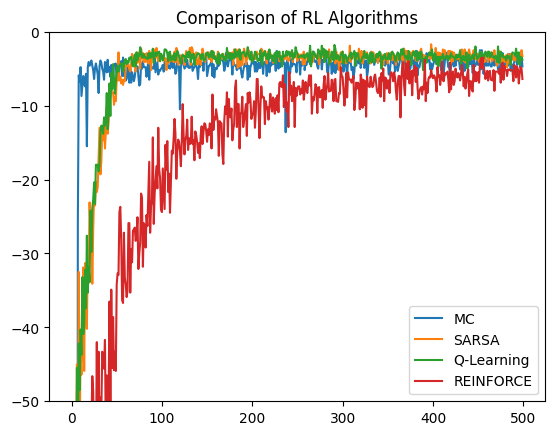

In [73]:
mc_rewards_avg = np.average(mc_rewards, axis=0)
sarsa_rewards_avg = np.average(sarsa_rewards, axis=0)
q_learning_rewards_avg = np.average(q_learning_rewards, axis=0)
reinforce_rewards_avg = np.average(reinforce_rewards, axis=0)

plt.figure()
plt.title('Comparison of RL Algorithms')
plt.plot(mc_rewards_avg, label='MC')
plt.plot(sarsa_rewards_avg, label='SARSA')
plt.plot(q_learning_rewards_avg, label='Q-Learning')
plt.plot(reinforce_rewards_avg, label='REINFORCE')
plt.ylim((-50.0, 0.0))
plt.legend()
plt.show()